Data Analysis Pipeline:


*  Clone the repo to carry the dependencies over and to invoke imagene.py.
*  Import all necessary modules.


*   Simulate data for strong and ancient selection selrange = seq 0 100 100 / timerange = 0.05, 50kya

*   Build and compile baseline model.Gather Baseline metrics e.g accuracy, F1 and confusion matrixes


*   Train model on training data and gather metrics.

*   Test trained network on unseen data. The 10th Batch of Data













In [1]:
# Cloning the GitHub repository
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Change directories into the specified directory
%cd EvoNet-CNN-Insight/model_training/intermediate_weak



Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 4234, done.
remote: Counting objects: 100% (1051/1051), done.
remote: Compressing objects: 100% (678/678), done.
remote: Total 4234 (delta 538), reused 768 (delta 370), pack-reused 3183
Receiving objects: 100% (4234/4234), 5.46 GiB | 33.09 MiB/s, done.
Resolving deltas: 100% (1438/1438), done.
Updating files: 100% (207/207), done.
/content/EvoNet-CNN-Insight/model_training/intermediate_weak


In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import arviz

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers



# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc
import pydot  # Optional, but required by keras to plot the model

In [3]:
%run -i ../../ImaGene.py

In [4]:
path = './'

ImaGene uses msms for simulations to train networks. Run generate_dataset.sh with params.txt. Simulates 200,000 loci (80kbp) under neutral evolution or positive selection (additive effect, s=100). Selection starts 100kya (allele frequency 0.01), mutation rate 1.5e-8, recombination rate 1e-8. Follows a 3-epoch model (Marth et al. 2004) for a European population, sampling 198 chromosomal copies. The script splits simulations into batches for training.


In [5]:
import subprocess

# Run the simulation script with specified parameters
subprocess.call("bash ../../generate_dataset.sh params_intermediate_weak.txt".split());


Processing batch 1
29/29 [==============================] - 93s 3s/step - loss: 5.7373 - accuracy: 0.5278 - val_loss: 4.1467 - val_accuracy: 0.5050
Processing batch 2
29/29 [==============================] - 91s 3s/step - loss: 3.3048 - accuracy: 0.5850 - val_loss: 2.5057 - val_accuracy: 0.5850
Processing batch 3
29/29 [==============================] - 87s 3s/step - loss: 1.9984 - accuracy: 0.5622 - val_loss: 1.9235 - val_accuracy: 0.5100
Processing batch 4
29/29 [==============================] - 88s 3s/step - loss: 1.3972 - accuracy: 0.6178 - val_loss: 1.3457 - val_accuracy: 0.5250
Processing batch 5
29/29 [==============================] - 89s 3s/step - loss: 1.1139 - accuracy: 0.6328 - val_loss: 0.9774 - val_accuracy: 0.6950
Processing batch 6
29/29 [==============================] - 89s 3s/step - loss: 0.9628 - accuracy: 0.6917 - val_loss: 1.4013 - val_accuracy: 0.5600
Processing batch 7
29/29 [==============================] - 91s 3s/step - loss: 0.8759 - accuracy: 0.7428 - val_

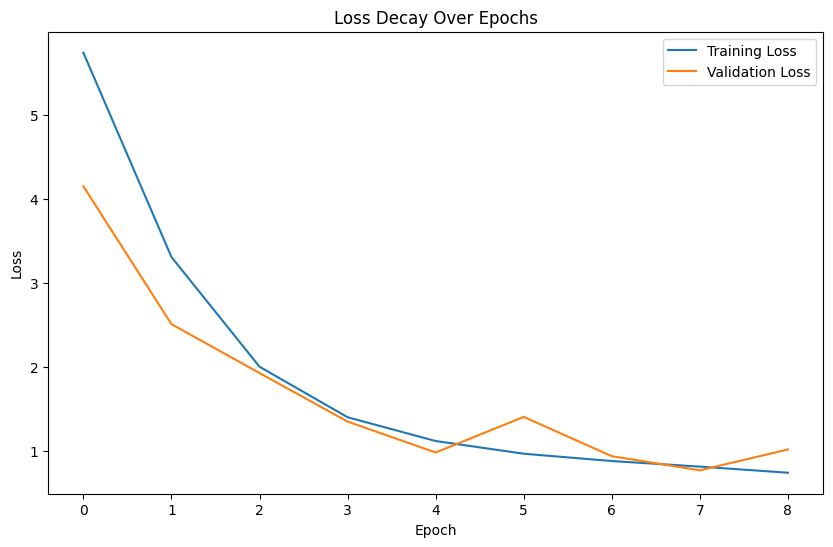

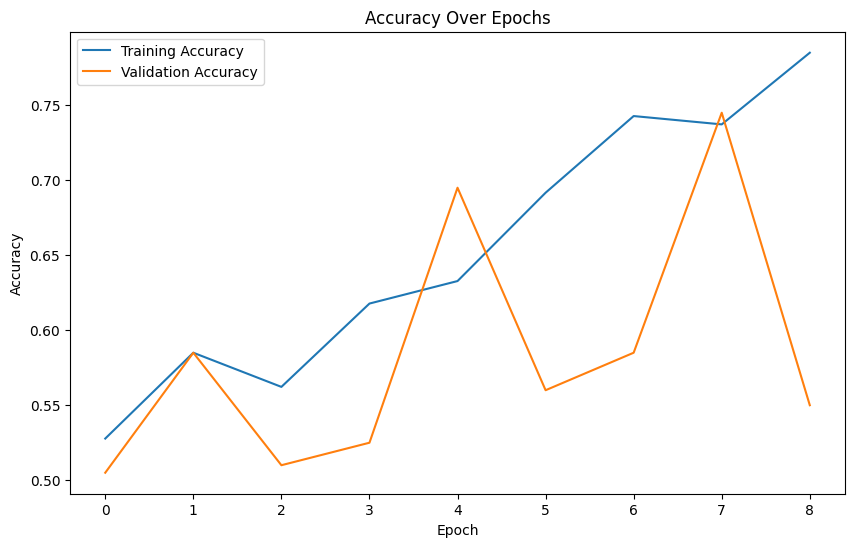

In [6]:
path_sim = './'

# Initialize variables to store training metrics and total number of epochs
total_epochs = 0
losses = []
val_losses = []
accuracies = []
val_accuracies = []

# Loop to iterate through different simulation datasets
i = 1
while i <= 9:  # Only iterate from 1 to 9 for training
    print(f'Processing batch {i}')

    # Simulations
    file_sim = ImaFile(simulations_folder=path_sim + 'IW/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

    # Manipulate data:
    # Filter out monomorphic sites, sort rows by genetic distance
    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    # Randomize data
    gene_sim.subset(get_index_random(gene_sim))

    # Convert targets to binary data
    gene_sim.targets = to_binary(gene_sim.targets)

    # At the first iteration, we build the model
    if i == 1:
        model = models.Sequential([
            layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu',
                          kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid',
                          input_shape=gene_sim.data.shape[1:]),
            layers.MaxPooling2D(pool_size=(2,2)),
            layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu',
                          kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
            layers.MaxPooling2D(pool_size=(2,2)),
            layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu',
                          kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
            layers.MaxPooling2D(pool_size=(2,2)),
            layers.Flatten(),
            layers.Dense(units=128, activation='relu'),
            layers.Dense(units=1, activation='sigmoid')
        ])
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

        net_LCT = ImaNet(name='[C32+P]x2+[C64+P]+D128')

    # Training for iterations from 1 to 9
    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)
    losses.extend(score.history['loss'])
    val_losses.extend(score.history['val_loss'])
    accuracies.extend(score.history['accuracy'])
    val_accuracies.extend(score.history['val_accuracy'])
    total_epochs += len(score.history['loss'])
    net_LCT.update_scores(score)

    # Increment the loop counter
    i += 1

# Print the total number of epochs
print(f'Total epochs trained: {total_epochs}')

# Plot the loss and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), losses, label='Training Loss')
plt.plot(range(total_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Decay Over Epochs')
plt.legend()
plt.show()

# Plot the accuracy and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), accuracies, label='Training Accuracy')
plt.plot(range(total_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()


[0.9975661039352417, 0.5799999833106995]
63/63 [==============================] - 26s 415ms/step


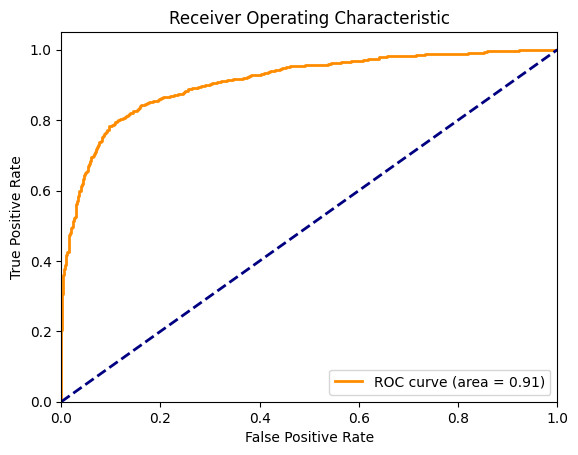

Sensitivity (Recall): 0.99
Specificity: 0.17
Precision: 0.54
F1 Score: 0.70


In [7]:
# Evaluation on the 10th batch
i = 10
file_sim = ImaFile(simulations_folder=path_sim + 'IW/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

gene_sim_test.filter_freq(0.01)
gene_sim_test.sort('rows_freq')
gene_sim_test.resize((198, 192))
gene_sim_test.convert(flip=True)

rnd_idx = get_index_random(gene_sim_test) # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

gene_sim_test.targets = to_binary(gene_sim_test.targets)

# Report loss and accuracy on the testing set
net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(net_LCT.test)  # it will report [loss, accuracy]

# Add ROC and AUC calculation and plotting
y_pred_prob = model.predict(gene_sim_test.data)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(gene_sim_test.targets, y_pred).ravel()

# Calculate sensitivity (recall)
sensitivity = recall_score(gene_sim_test.targets, y_pred)

# Calculate specificity
specificity = tn / (tn + fp)

# Calculate precision
precision = precision_score(gene_sim_test.targets, y_pred)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, y_pred)

# Print metrics
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")


We save (and/or load) the final trained model.

In [8]:
model.save(path + 'model.IW.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
model = load_model(path + 'model.IW.h5')

Finally, we evaluate the training on the testing dataset, which is the 10th batch of data

For a binary (or multiclass) classification, it is convenient to plot the confusion matrix after predicting the responses from the testing data.

63/63 [==============================] - 26s 411ms/step


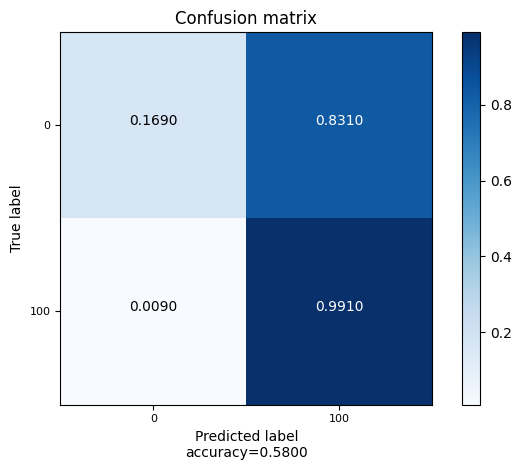

0

In [10]:
net_LCT.predict(gene_sim_test, model)
net_LCT.plot_cm(gene_sim_test.classes, text=True)